# Modeling Experiments

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-10-27

Python notebook re: training more complex models (ensembles, regularized, etc.); including performance tables/plots across folds; documenting failed experiments and iteration decisions.

Input(s):
- `../data/processed/train_calib_selected.csv`: training/calibration split with only selected features plus metadata (`user`, `gesture`, `stage`)
- `../data/processed/train_calib_full.csv`: training/calibration split with all 160 features for full-feature model experiments
- `../data/processed/test_holdout_full.csv`: test holdout split with all 160 features for full-feature model experiments
- `../results/feature_selection.csv`: produced by the feature selection step; used here only for reporting

Main output(s):
- `../results/model_comparison.csv`: Tabular record of model family, hyperparameters, and KPI scores

**Personalization rationale for generic neuromotor interface (GNI):**
- sEMG signals exhibit high inter-user variability due to anatomical differences,
  electrode placement, skin impedance, and motor unit recruitment patterns
- Personalization evaluates model performance on the SAME user's unseen data,
  simulating real-world deployment where users calibrate the interface
- (Contrasts with generalization (`GroupKFold`) which tests on unseen users)
- Personalization is essential for practical neuromotor interfaces as demonstrated
  in the GNI research by Kaifosh et al. (2025)
- `StratifiedKFold` maintains gesture class distribution within each user's splits

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

# Global config
RANDOM_STATE = 13
PERSONALIZATION_K = 5 # Folds per user for within-user evaluation

# Define primary & secondary metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [2]:
# Define primary & secondary metrics for personalization
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

# Define CV strategy for PERSONALIZATION (within-user eval)
# split each user's data into train/test to eval personalization accuracy
from sklearn.model_selection import StratifiedKFold

# Use StratifiedKFold w/i each user to maintain gesture distribution
PERSONALIZATION_K = 5
cv_strategy = StratifiedKFold(n_splits=PERSONALIZATION_K, shuffle=True, random_state=RANDOM_STATE)

# Confirm
print(f"Cross-validation strategy: StratifiedKFold with {PERSONALIZATION_K} splits (within-user personalization)")

Cross-validation strategy: StratifiedKFold with 5 splits (within-user personalization)


### Selected feature set

In [3]:
# Load training/calibration data w/ selected features
df_train = pd.read_csv("../data/processed/train_calib_selected.csv")

TARGET = 'gesture'
GROUP = 'user'
# 'stage' included as metadata
metadata_cols = [GROUP, TARGET, 'stage'] 
final_features = [col for col in df_train.columns if col not in metadata_cols]

X = df_train[final_features]
y_raw = df_train[TARGET]
groups = df_train[GROUP]

# Encode target labels
le = LabelEncoder()
y = pd.Series(le.fit_transform(y_raw), index=y_raw.index)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Unique users (groups): {groups.nunique()}, Unique gestures: {y.nunique()}")

X shape: (102502, 37), y shape: (102502,)
Unique users (groups): 100, Unique gestures: 9


In [4]:
# Inspect
X.head(5)

,ch05_maxabs,ch04_rms,ch06_rms,ch03_rms,ch10_rms,ch05_fft-maxpower,ch14_rms,ch15_rms,ch07_rms,ch13_rms,...,ch05_thresh3-events,ch04_fft-highfreq,ch04_thresh3-events,ch02_thresh2-events,ch07_thresh2-events,ch12_thresh2-events,ch10_thresh2-events,ch13_thresh2-events,ch01_thresh2-events,ch03_fft-highfreq
0,29.595093,7.912351,11.195332,4.977164,108.731950,156.587197,19.135984,9.903959,19.699449,20.452117,...,0.0,172.727273,0.0,1.0,5.0,4.0,7.0,3.0,0.0,163.636364
1,46.239792,12.459173,17.233520,9.468772,108.731950,418.249377,30.331288,18.193514,25.799284,30.410862,...,2.0,218.181818,1.0,7.0,6.0,9.0,13.0,5.0,8.0,127.272727
2,52.461903,12.047217,19.201527,12.614996,104.977276,316.290936,24.297671,16.543425,29.189332,29.627513,...,4.0,209.090909,1.0,8.0,10.0,6.0,9.0,5.0,8.0,136.363636
3,33.767937,9.377417,15.306242,8.830684,108.731950,234.024608,31.570821,16.154616,26.161635,28.088110,...,2.0,236.363636,0.0,4.0,8.0,3.0,8.0,4.0,2.0,154.545455
4,23.548090,6.696506,10.966422,4.482511,72.787082,139.002096,15.250938,7.401663,17.149855,16.356909,...,0.0,181.818182,0.0,0.0,4.0,2.0,5.0,2.0,0.0,181.818182


In [5]:
# Create label mapping using original encoder from data loading
# already encoded y_raw to y, so use same encoder
class_names = le.classes_

# dataframe for label mapping
label_mapping_df = pd.DataFrame({
    'Encoded_label': range(len(class_names)),
    'Gesture_Class': class_names
})

# Inspect
label_mapping_df

,Encoded_label,Gesture_Class
0,0,index_press
1,1,index_release
2,2,middle_press
3,3,middle_release
4,4,thumb_click
5,5,thumb_down
6,6,thumb_in
7,7,thumb_out
8,8,thumb_up


### Full feature set

In [6]:
# LOAD FULL FEATURE SETS FOR REGULARIZED MODELS 
# Load training/calibration data w/ ALL 160 features
df_train_full = pd.read_csv("../data/processed/train_calib_full.csv")
df_test_full = pd.read_csv("../data/processed/test_holdout_full.csv")

# Define full feature set (160 features)
full_features = [col for col in df_train_full.columns if col not in metadata_cols]

# Create full feature datasets
X_full = df_train_full[full_features]

## Modeling experiments (cross-validation)

### Define models to test

In [7]:
# DEFINE MODELS TO TEST, INCL CLASS IMBALANCE & FEATURE STRATEGIES

# Define reusable preprocessing pipeline step, log transform is to address the right-skewness of our data
preprocessor = Pipeline([('log_transform', FunctionTransformer(np.log1p)),('scaler', StandardScaler())])

models_to_test = {
    'DummyClassifier': Pipeline([
        ('prep', preprocessor),
        ('clf', DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))
    ]),
    'Logit_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE
        ))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100, max_depth=6, random_state=RANDOM_STATE, n_jobs=1,
            class_weight='balanced'  # for imbalance
        ))
    ]),
    'DecisionTree': Pipeline([
        ('prep', preprocessor),
        ('clf', DecisionTreeClassifier(
            max_depth=10, random_state=RANDOM_STATE,
            class_weight='balanced'  # for imbalance
        ))
    ]),    # Class-weighted logistic regression on selected features
    'Logit_Weighted_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            random_state=RANDOM_STATE,
            class_weight='balanced'  # to address imbalance 
        ))
    ]),
    # Class-weighted logistic regression on all 160 features
    'Logit_Weighted_All_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            random_state=RANDOM_STATE,
            class_weight='balanced',  # Combine high-dimensional features w/ class balancing
            C=0.1  # STRONGER REGULARIZATION?
        ))
    ]),
    # Standard logistic regression on all 160 features
    'Logit_All_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            random_state=RANDOM_STATE,
            C=0.1  # STRONGER REGULARIZATION?
        ))
    ])
}

# Define which models use which feature set
model_feature_mapping = {
    'Logit_All_L2': X_full,
    'Logit_Weighted_All_L2': X_full,
}

In [8]:
# Add XGBoost to model comparison (same CV strategy as other models)
models_to_test['XGBoost'] = Pipeline([
    ('prep', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=100, max_depth=6,
        learning_rate=0.1, subsample=0.9, colsample_bytree=0.9,
        objective='multi:softprob', eval_metric='mlogloss',
        random_state=RANDOM_STATE, n_jobs=1
    ))
])


**XGBoost Gain Feature Importance**

This helps verify whether the XGBoost model is relying on the same key channels (e.g., **ch05, ch04, ch10**) surfaced by the prior feature selection.


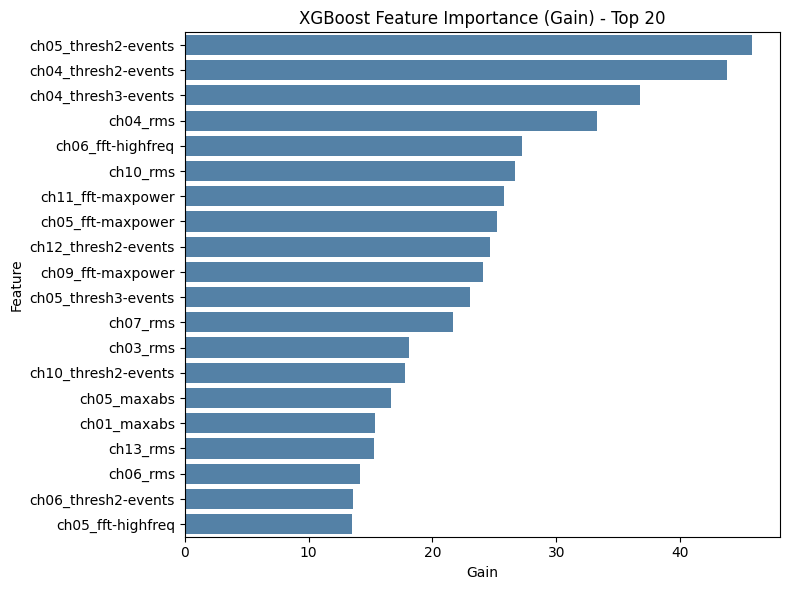

In [9]:
# Fit XGBoost on selected features and plot Gain-based feature importance
xgb_pipeline = models_to_test['XGBoost']
xgb_pipeline.fit(X, y)
booster = xgb_pipeline.named_steps['clf'].get_booster()
gain_scores = booster.get_score(importance_type='gain')

# Map f0..fN to feature names
feature_names = list(X.columns)
importance_rows = []
for k, v in gain_scores.items():
    # XGBoost uses f{index} naming
    if k.startswith('f'):
        idx = int(k[1:])
        if idx < len(feature_names):
            importance_rows.append((feature_names[idx], v))

gain_df = pd.DataFrame(importance_rows, columns=['feature', 'gain'])
gain_df = gain_df.sort_values('gain', ascending=False)

# Plot top 20 gain features
top_gain = gain_df.head(20)
plt.figure(figsize=(8, 6))
sns.barplot(data=top_gain, x='gain', y='feature', color='steelblue')
plt.title('XGBoost Feature Importance (Gain) - Top 20')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [10]:
# Cache directory for model results
import joblib
from pathlib import Path
CACHE_DIR = Path("../cache")
CACHE_DIR.mkdir(exist_ok=True)

def run_personalization_cv(model, X, y, groups, name, k_folds, scoring_metrics, use_cache=True):
    """
    Evaluates model performance averaged across all users using StratifiedKFold within each user.
    Returns both aggregate results and per-user results for swarm plot visualization.
    """

    # Create a unique identifier for this specific model configuration
    model_params = model.named_steps['clf'].get_params(deep=False)
    data_shape = X.shape
    config_hash = joblib.hash({'name': name, 'params': model_params, 'data_shape': data_shape, 'k_folds': k_folds})

    cache_file = CACHE_DIR / f"personalization_{config_hash}.pkl"
    user_results_cache_file = CACHE_DIR / f"personalization_{config_hash}_user_results.pkl"

    # Return cached results if available
    if use_cache and cache_file.exists() and user_results_cache_file.exists():
        print(f"  Loading cached results for {name}...")
        aggregate_result = joblib.load(cache_file)
        user_results_df = joblib.load(user_results_cache_file)
        return aggregate_result, user_results_df

    unique_users = groups.unique()
    all_f1_scores = []
    all_acc_scores = []
    users_evaluated = 0
    users_skipped = 0

    # Store per-user results for swarm plot
    per_user_results = []

    cv_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

    for user in unique_users:
        # Isolate data for current user
        user_indices = groups[groups == user].index
        X_user = X.loc[user_indices]
        y_user = y.loc[user_indices]

        # Ensure sufficient samples & classes for StratifiedKFold
        class_counts = y_user.value_counts()
        if len(class_counts) < k_folds or class_counts.min() < k_folds:
            print(f"Warning: Skipping user {user} due to insufficient per-class samples for {k_folds}-fold CV")
            users_skipped += 1
            continue

        f1_scores = []
        acc_scores = []

        # Cross-validation w/i current user's data
        for train_idx, test_idx in cv_splitter.split(X_user, y_user):
            X_train = X_user.iloc[train_idx]
            X_test = X_user.iloc[test_idx]
            y_train = y_user.iloc[train_idx]
            y_test = y_user.iloc[test_idx]

            # Local label encoding per fold to ensure contiguous class IDs
            fold_le = LabelEncoder()
            y_train_enc = fold_le.fit_transform(y_train)
            y_test_enc = fold_le.transform(y_test)

            # Clone model to ensure fresh fit for ea fold
            user_model = clone(model)
            user_model.fit(X_train, y_train_enc)
            y_pred = user_model.predict(X_test)

            f1_scores.append(f1_score(y_test_enc, y_pred, average='macro', zero_division=0))
            acc_scores.append(accuracy_score(y_test_enc, y_pred))

        all_f1_scores.extend(f1_scores)
        all_acc_scores.extend(acc_scores)
        users_evaluated += 1

        # Capture per-user metrics for swarm plot
        user_mean_accuracy = np.mean(acc_scores)
        user_sample_count = len(X_user)

        per_user_results.append({
            'Model': name,
            'User_ID': user,
            'Mean_User_Accuracy': user_mean_accuracy,
            'Sample_Count': user_sample_count,
            'Folds_Processed': len(acc_scores)
        })

    # Calc overall mean & stdev across all folds
    mean_f1 = np.mean(all_f1_scores)
    std_f1 = np.std(all_f1_scores)
    mean_acc = np.mean(all_acc_scores)
    std_acc = np.std(all_acc_scores)

    # Extract hyperparams
    hyperparams = model.named_steps['clf'].get_params(deep=False)

    aggregate_result = {
        'Model': name,
        'Mean_Accuracy': mean_acc,
        'Std_Accuracy': std_acc,
        'Mean_F1_Macro': mean_f1,
        'Std_F1_Macro': std_f1,
        'Hyperparameters': str(hyperparams),
        'N_Users_Evaluated': users_evaluated,
        'N_Users_Skipped': users_skipped,
        'Total_Folds': len(all_f1_scores),
        'Config_Hash': config_hash
    }

    # Create per-user results df
    user_results_df = pd.DataFrame(per_user_results)

    print(f"  {name}: {users_evaluated} users evaluated, {users_skipped} skipped")

    # Cache both aggregate & per-user results
    if use_cache:
        joblib.dump(aggregate_result, cache_file)
        joblib.dump(user_results_df, user_results_cache_file)
        print(f"  Cached results for {name}")

    return aggregate_result, user_results_df


#### (Optional) Caching

In [11]:
# Check which models already cached and only run new ones
cached_models = []
new_models = []

for name, model in models_to_test.items():
    # Select appropriate feature set for each model
    if name in model_feature_mapping:
        X_model = model_feature_mapping[name]
    else:
        X_model = X
    
    # Create same unique identifier used in function
    model_params = model.named_steps['clf'].get_params(deep=False)
    data_shape = X_model.shape
    config_hash = joblib.hash({'name': name, 'params': model_params, 'data_shape': data_shape, 'k_folds': PERSONALIZATION_K})
    
    cache_file = CACHE_DIR / f"personalization_{config_hash}.pkl"
    
    if cache_file.exists():
        cached_models.append(name)
    else:
        new_models.append(name)

print(f"Found {len(cached_models)} cached models: {cached_models}")
print(f"Found {len(new_models)} new models to run: {new_models}")

Found 8 cached models: ['DummyClassifier', 'Logit_L2', 'RandomForest', 'DecisionTree', 'Logit_Weighted_L2', 'Logit_Weighted_All_L2', 'Logit_All_L2', 'XGBoost']
Found 0 new models to run: []


In [12]:
# # Delete cache for all currently defined models
# for name, model in models_to_test.items():
#     # Select appropriate feature set for ea model
#     if name in model_feature_mapping:
#         X_model = model_feature_mapping[name]
#     else:
#         X_model = X
    
#     # Create same unique identifier used in fn
#     model_params = model.named_steps['clf'].get_params(deep=False)
#     data_shape = X_model.shape
#     config_hash = joblib.hash({'name': name, 'params': model_params, 'data_shape': data_shape, 'k_folds': PERSONALIZATION_K})
    
#     cache_file = CACHE_DIR / f"personalization_{config_hash}.pkl"
#     user_cache_file = CACHE_DIR / f"personalization_user_{config_hash}.pkl"
    
#     deleted_count = 0
#     for file_path in [cache_file, user_cache_file]:
#         if file_path.exists():
#             file_path.unlink()
#             deleted_count += 1
    
#     if deleted_count > 0:
#         print(f"Deleted {deleted_count} cache files for {name}")

# print("Cache cleanup complete")

#### Run model evaluation loop

In [13]:
# Define which models use which feature set
# Full feature models should use X_full (160 features)
model_feature_mapping = {
    'Logit_All_L2': X_full,           # Should be 160 features
    'Logit_Weighted_All_L2': X_full,  # Should be 160 features
    # Other models use X (w/ # of selected features)
}

# Use personalization eval w/ caching
results = []
all_user_results = []  # Collect per-user results from all models

for name, model in models_to_test.items():
    # Select appropriate feature set for each model
    if name in model_feature_mapping:
        X_model = model_feature_mapping[name]
        feature_type = "full features"
    else:
        X_model = X  # Default to selected feats
        feature_type = "selected features"
    
    print(f"Evaluating {name} with {feature_type} ({X_model.shape[1]} features)")
    
    res, user_res = run_personalization_cv(model, X_model, y, groups, name, PERSONALIZATION_K, scoring_metrics, use_cache=True)
    results.append(res)
    all_user_results.append(user_res)  # Collect per-user results

# Combine all per-user results into single df for swarm plot
user_performance_df = pd.concat(all_user_results, ignore_index=True)

results_df = pd.DataFrame(results).sort_values(by='Mean_F1_Macro', ascending=False)
results_df

Evaluating DummyClassifier with selected features (37 features)
  Loading cached results for DummyClassifier...
Evaluating Logit_L2 with selected features (37 features)
  Loading cached results for Logit_L2...
Evaluating RandomForest with selected features (37 features)
  Loading cached results for RandomForest...
Evaluating DecisionTree with selected features (37 features)
  Loading cached results for DecisionTree...
Evaluating Logit_Weighted_L2 with selected features (37 features)
  Loading cached results for Logit_Weighted_L2...
Evaluating Logit_Weighted_All_L2 with full features (160 features)
  Loading cached results for Logit_Weighted_All_L2...
Evaluating Logit_All_L2 with full features (160 features)
  Loading cached results for Logit_All_L2...
Evaluating XGBoost with selected features (37 features)
  Loading cached results for XGBoost...


,Model,Mean_Accuracy,Std_Accuracy,Mean_F1_Macro,Std_F1_Macro,Hyperparameters,N_Users_Evaluated,N_Users_Skipped,Total_Folds,Config_Hash
1,Logit_L2,0.726952,0.121740,0.709758,0.122941,"{'C': 1.0, 'class_weight': None, 'dual': False...",100,0,500,374ce5ecda326af3546d2f8babf23c6b
4,Logit_Weighted_L2,0.720680,0.121235,0.701566,0.120780,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",100,0,500,f044ea513919a3fec93929a03268b33c
5,Logit_Weighted_All_L2,0.718791,0.125338,0.696951,0.126050,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",100,0,500,fb6d0b5aef71515e11d682a758d77eae
6,Logit_All_L2,0.720414,0.124784,0.695364,0.126659,"{'C': 0.1, 'class_weight': None, 'dual': False...",100,0,500,fd71246debe7ef560852235d66a109a6
7,XGBoost,0.684486,0.126672,0.650697,0.121876,"{'objective': 'multi:softprob', 'base_score': ...",99,1,495,57b1cc4b598d04c0311169666051097d
2,RandomForest,0.640239,0.118468,0.609939,0.114789,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",100,0,500,fc5efe6019334fb1f27f616e8cb7931a
3,DecisionTree,0.537754,0.127280,0.499603,0.113841,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",100,0,500,bc8da28a062d7a600d1974c5e7bdb837
0,DummyClassifier,0.149110,0.044413,0.109728,0.022032,"{'constant': None, 'random_state': 13, 'strate...",100,0,500,50a819d4c190f81396bd0ba64395c341


### Model comparison summary

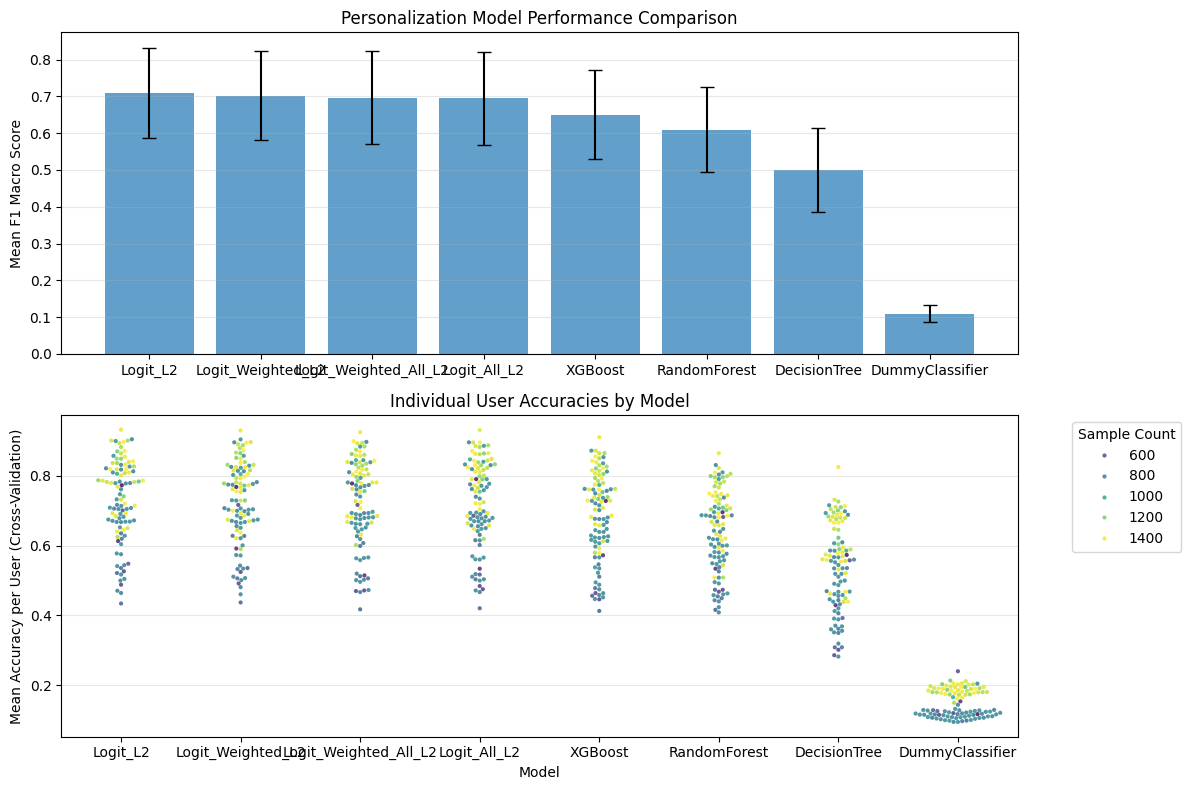

In [14]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Get model order from results_df (sorted by performance)
model_order = results_df['Model'].tolist()

# Subplot: Model performance comparison
bars = ax1.bar(results_df['Model'], results_df['Mean_F1_Macro'], 
               yerr=results_df['Std_F1_Macro'], capsize=5, alpha=0.7)
ax1.set_ylabel('Mean F1 Macro Score')
ax1.set_title('Personalization Model Performance Comparison')
ax1.grid(axis='y', alpha=0.3)
# ax1.tick_params(axis='x', rotation=45)

# Subplot: Swarm plot
swarm_plot = sns.swarmplot(
    x='Model', 
    y='Mean_User_Accuracy', 
    hue='Sample_Count', 
    data=user_performance_df, 
    size=3,  # Reduced from 4 to minimize overlap
    palette='viridis',
    alpha=0.8,
    ax=ax2,
    order=model_order  # same order as bar plot
)
ax2.set_ylabel('Mean Accuracy per User (Cross-Validation)')
# ax2.set_xlabel('Model')
ax2.set_title('Individual User Accuracies by Model')
ax2.legend(title='Sample Count', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, axis='y', alpha=0.3)
# ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# Per-model stats
model_stats = user_performance_df.groupby('Model').agg({
    'Mean_User_Accuracy': ['mean', 'std', 'min', 'max']
}).round(4)

model_stats.columns = ['Accuracy_Mean', 'Accuracy_Std', 'Accuracy_Min', 'Accuracy_Max']
model_stats = model_stats.sort_values('Accuracy_Mean', ascending=False)

# Inspect: model performance, sorted by mean accuracy
model_stats

,Accuracy_Mean,Accuracy_Std,Accuracy_Min,Accuracy_Max
Model,,,,
Logit_L2,0.7270,0.1189,0.4342,0.9324
Logit_Weighted_L2,0.7207,0.1182,0.4373,0.9303
Logit_All_L2,0.7204,0.1223,0.4206,0.9310
Logit_Weighted_All_L2,0.7188,0.1228,0.4175,0.9252
XGBoost,0.6845,0.1240,0.4130,0.9109
RandomForest,0.6402,0.1148,0.4087,0.8648
DecisionTree,0.5378,0.1240,0.2821,0.8253
DummyClassifier,0.1491,0.0387,0.0947,0.2401


### Save model_comparison.csv

In [16]:
# Save current results (overwrites existing model_comparison.csv)
clean_results = results_df.copy()

# Remove any columns that are all NaN/contain NaN values
clean_results = clean_results.loc[:, ~clean_results.isna().all()]
clean_results = clean_results.dropna(axis=1, how='all')

# Save comparison table
RESULTS_PATH = "../results/model_comparison.csv"
os.makedirs(os.path.dirname(RESULTS_PATH), exist_ok=True)

# Add experiment timestamp and save current results only
clean_results['experiment_date'] = pd.Timestamp.now().strftime('%Y-%m-%d')
clean_results['experiment_timestamp'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')

# Inspect
clean_results

,Model,Mean_Accuracy,Std_Accuracy,Mean_F1_Macro,Std_F1_Macro,Hyperparameters,N_Users_Evaluated,N_Users_Skipped,Total_Folds,Config_Hash,experiment_date,experiment_timestamp
1,Logit_L2,0.726952,0.121740,0.709758,0.122941,"{'C': 1.0, 'class_weight': None, 'dual': False...",100,0,500,374ce5ecda326af3546d2f8babf23c6b,2026-02-07,2026-02-07 11:01:17
4,Logit_Weighted_L2,0.720680,0.121235,0.701566,0.120780,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",100,0,500,f044ea513919a3fec93929a03268b33c,2026-02-07,2026-02-07 11:01:17
5,Logit_Weighted_All_L2,0.718791,0.125338,0.696951,0.126050,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",100,0,500,fb6d0b5aef71515e11d682a758d77eae,2026-02-07,2026-02-07 11:01:17
6,Logit_All_L2,0.720414,0.124784,0.695364,0.126659,"{'C': 0.1, 'class_weight': None, 'dual': False...",100,0,500,fd71246debe7ef560852235d66a109a6,2026-02-07,2026-02-07 11:01:17
7,XGBoost,0.684486,0.126672,0.650697,0.121876,"{'objective': 'multi:softprob', 'base_score': ...",99,1,495,57b1cc4b598d04c0311169666051097d,2026-02-07,2026-02-07 11:01:17
2,RandomForest,0.640239,0.118468,0.609939,0.114789,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",100,0,500,fc5efe6019334fb1f27f616e8cb7931a,2026-02-07,2026-02-07 11:01:17
3,DecisionTree,0.537754,0.127280,0.499603,0.113841,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",100,0,500,bc8da28a062d7a600d1974c5e7bdb837,2026-02-07,2026-02-07 11:01:17
0,DummyClassifier,0.149110,0.044413,0.109728,0.022032,"{'constant': None, 'random_state': 13, 'strate...",100,0,500,50a819d4c190f81396bd0ba64395c341,2026-02-07,2026-02-07 11:01:17


In [17]:
# Save file w/ current results
clean_results.to_csv(RESULTS_PATH, index=False)
print(f"Saved {len(clean_results)} models from current experiment")

Saved 8 models from current experiment


## Model selection and interpretation

### Feature importance analysis

In [18]:
# Analyze feature importance for ALL models
feature_importance_results = {}

# UPDATED FEATURE IMPORTANCE ANALYSIS W/ NORMALIZATION 
# Fix XGBoost warning by removing use_label_encoder param
models_to_test['XGBoost'] = Pipeline([
    ('prep', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=100, max_depth=6,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE, n_jobs=1
    ))
])

model_names = [key for key in models_to_test.keys() if key != 'DummyClassifier']

# Collect feature importance data
importance_data = {}
feature_importance_results = {}

for model_name in model_names:
    # Select appropriate feature set for ea model
    if model_name in model_feature_mapping:
        X_model = model_feature_mapping[model_name]
        features_to_use = full_features
    else:
        X_model = X
        features_to_use = final_features
        
    pipeline = models_to_test[model_name]
    pipeline.fit(X_model, y)

    if hasattr(pipeline.named_steps['clf'], 'feature_importances_'):
        # Tree-based models: importance scores already normalized (sum to 1)
        importances = pipeline.named_steps['clf'].feature_importances_
    else:
        # Linear models: use absolute mean coefficient magnitude
        coefficients = pipeline.named_steps['clf'].coef_
        importances = np.mean(np.abs(coefficients), axis=0)
        
        # CRITICAL: Normalize linear model coefficients for cross-model comparison
        if np.sum(importances) > 0:
            importances = importances / np.sum(importances)

    feature_imp = pd.DataFrame({
        'feature': features_to_use,
        'importance': importances
    }).sort_values('importance', ascending=False)

    feature_importance_results[model_name] = feature_imp
    importance_data[model_name] = feature_imp.set_index('feature')['importance']

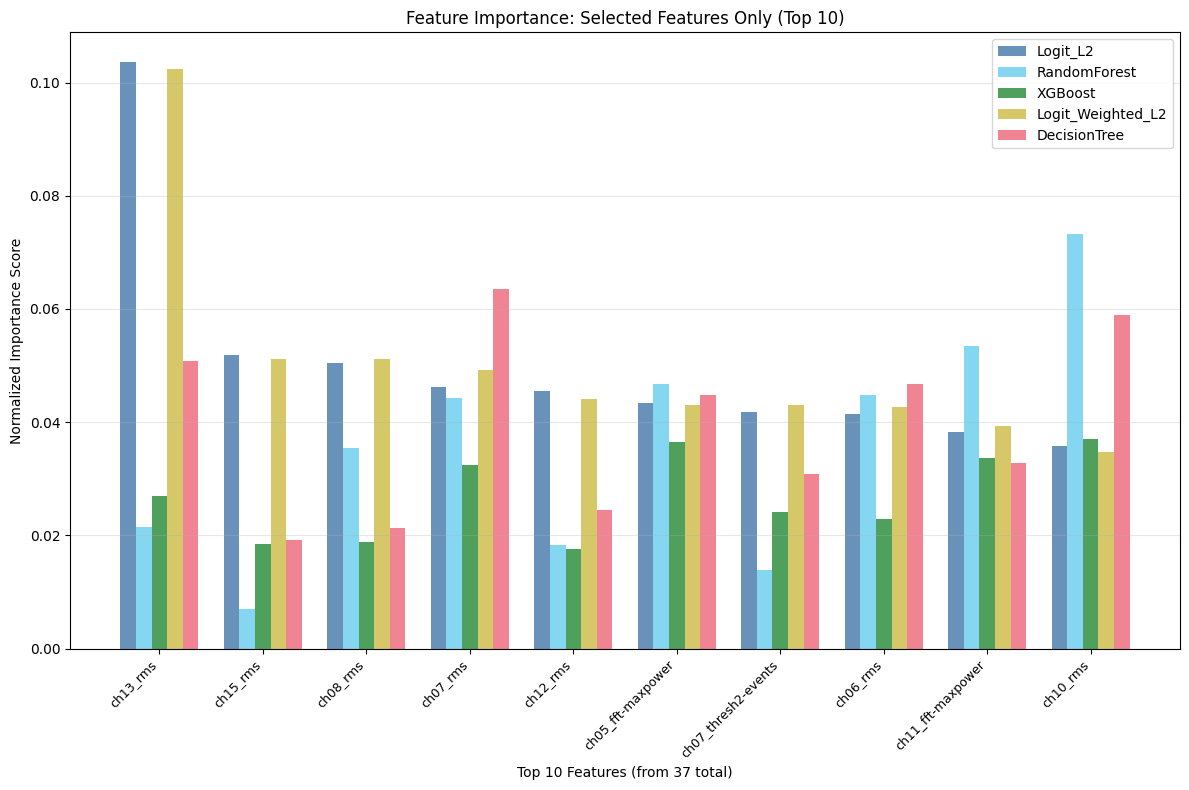

In [19]:
# Create separate plots for different model grps
fig, ax1 = plt.subplots(figsize=(12, 8))

# specify colors
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#BBBBBB', '#AA66CC']

# Plot: Models using SELECTED FEATS
selected_models = ['Logit_L2', 'RandomForest', 'XGBoost', 'Logit_Weighted_L2', 'DecisionTree']
selected_data = {}

# Collect data for selected feat models
for model in selected_models:
    if model in importance_data:
        selected_data[model] = importance_data[model]

selected_df = pd.DataFrame(selected_data)

# Sort by Logit_L2 importance, else use 1st model
if 'Logit_L2' in selected_df.columns:
    selected_df = selected_df.sort_values('Logit_L2', ascending=False)
else:
    selected_df = selected_df.sort_values(selected_df.columns[0], ascending=False)

# Get top 10 feats only
top_10_df = selected_df.head(10)

x1 = np.arange(len(top_10_df))
width = 0.15

for i, model in enumerate(selected_models):
    if model in top_10_df.columns:
        ax1.bar(x1 + i*width - width*2, top_10_df[model], width, 
                label=model, alpha=0.8, color=colors[i])

ax1.set_xlabel('Top 10 Features (from 37 total)')
ax1.set_ylabel('Normalized Importance Score')
ax1.set_title('Feature Importance: Selected Features Only (Top 10)')
ax1.set_xticks(x1)
ax1.set_xticklabels(top_10_df.index, rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

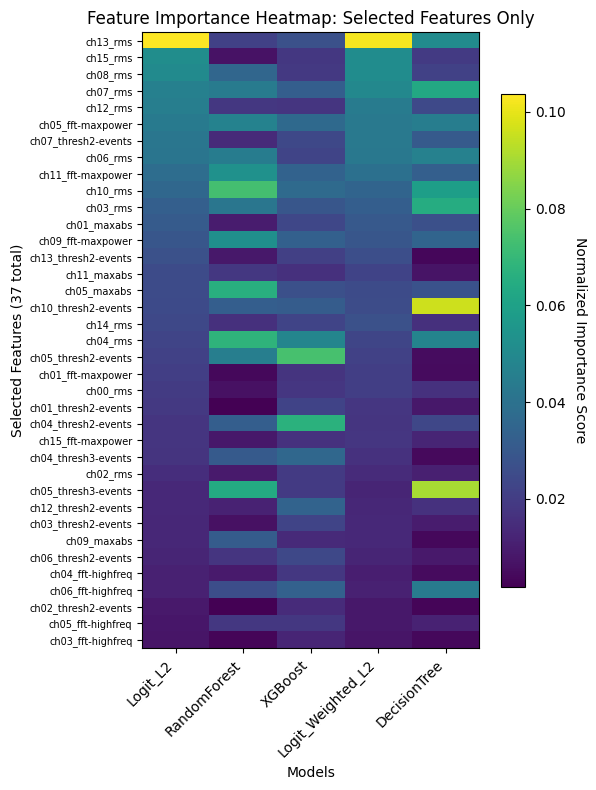

In [20]:
# Create heatmap for feature importance comparison
fig, ax1 = plt.subplots(figsize=(6, 8))

# Plot: Models using SELECTED FEATURES
selected_models = ['Logit_L2', 'RandomForest', 'XGBoost', 'Logit_Weighted_L2', 'DecisionTree']
selected_data = {}

# Collect data for selected feature models
for model in selected_models:
    if model in importance_data:
        selected_data[model] = importance_data[model]

selected_df = pd.DataFrame(selected_data)

# Sort by Logit_L2 importance
if 'Logit_L2' in selected_df.columns:
    selected_df = selected_df.sort_values('Logit_L2', ascending=False)

# Create heatmap - transpose the data to put models on x-axis and features on y-axis
im = ax1.imshow(selected_df, cmap='viridis', aspect='auto', interpolation='nearest')

ax1.set_xlabel('Models')
ax1.set_ylabel('Selected Features (37 total)')
ax1.set_title('Feature Importance Heatmap: Selected Features Only')
ax1.set_xticks(np.arange(len(selected_models)))
ax1.set_xticklabels(selected_models, rotation=45, ha='right')
ax1.set_yticks(np.arange(len(selected_df)))
ax1.set_yticklabels(selected_df.index, fontsize=7)

# Remove grid
ax1.grid(False)

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.set_label('Normalized Importance Score', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## Confusion matrix diagnostics

In [21]:
# Diagnostics: confusion matrix analysis

# ID best performing model re: F1 Macro score
best_model_row = results_df.loc[results_df['Mean_F1_Macro'].idxmax()]
best_model_name = best_model_row['Model']
print(f"Best performing model: {best_model_name} (F1 Macro: {best_model_row['Mean_F1_Macro']:.4f})")

# Use best performing model pipeline
best_pipeline = models_to_test[best_model_name]

# Select appropriate feature set for best model
if best_model_name in model_feature_mapping:
    X_best = model_feature_mapping[best_model_name]
else:
    X_best = X

# Initialize OOF collection
y_true_all = []
y_pred_all = []
unique_users = groups.unique()
k_folds = 5
cv_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

users_processed = 0
users_skipped = 0

for user in unique_users:
    # Isolate data for current user
    user_indices = groups[groups == user].index
    X_user = X_best.loc[user_indices]
    y_user = y.loc[user_indices]

    # Ensure sufficient samples/classes for StratifiedKFold
    if len(y_user.unique()) < k_folds:
        users_skipped += 1
        continue

    users_processed += 1

    # Generate OOF predictions w/i current user's data
    user_model = clone(best_pipeline)
    oof_pred_user = cross_val_predict(
        user_model,
        X_user,
        y_user,
        cv=cv_splitter,
        n_jobs=-1
    )

    y_true_all.extend(y_user.tolist())
    y_pred_all.extend(oof_pred_user.tolist())

# Convert lists back to np arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

print(f"Processed users: {users_processed} ({users_skipped} skipped)")
print(f"Total samples in analysis: {len(y_true_all)}")

# Get class names from label encoder used earlier
class_names = le.classes_

# Calculate confusion matrices
conf_mat = confusion_matrix(y_true_all, y_pred_all)

# Create confusion matrix w/ diagonal excluded
conf_mat_no_diag = conf_mat.copy()
np.fill_diagonal(conf_mat_no_diag, 0)

# Normalize matrices by row sum (to get Recall/classification rate per actual class)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
conf_mat_norm_no_diag = conf_mat_no_diag.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Handle potential division by zero
conf_mat_norm = np.nan_to_num(conf_mat_norm, nan=0.0)
conf_mat_norm_no_diag = np.nan_to_num(conf_mat_norm_no_diag, nan=0.0)

# Create dfs for better visualization
conf_mat_norm_df = pd.DataFrame(
    conf_mat_norm,
    columns=class_names,
    index=class_names
)

conf_mat_norm_no_diag_df = pd.DataFrame(
    conf_mat_norm_no_diag,
    columns=class_names,
    index=class_names
)

Best performing model: Logit_L2 (F1 Macro: 0.7098)


Processed users: 100 (0 skipped)
Total samples in analysis: 102502


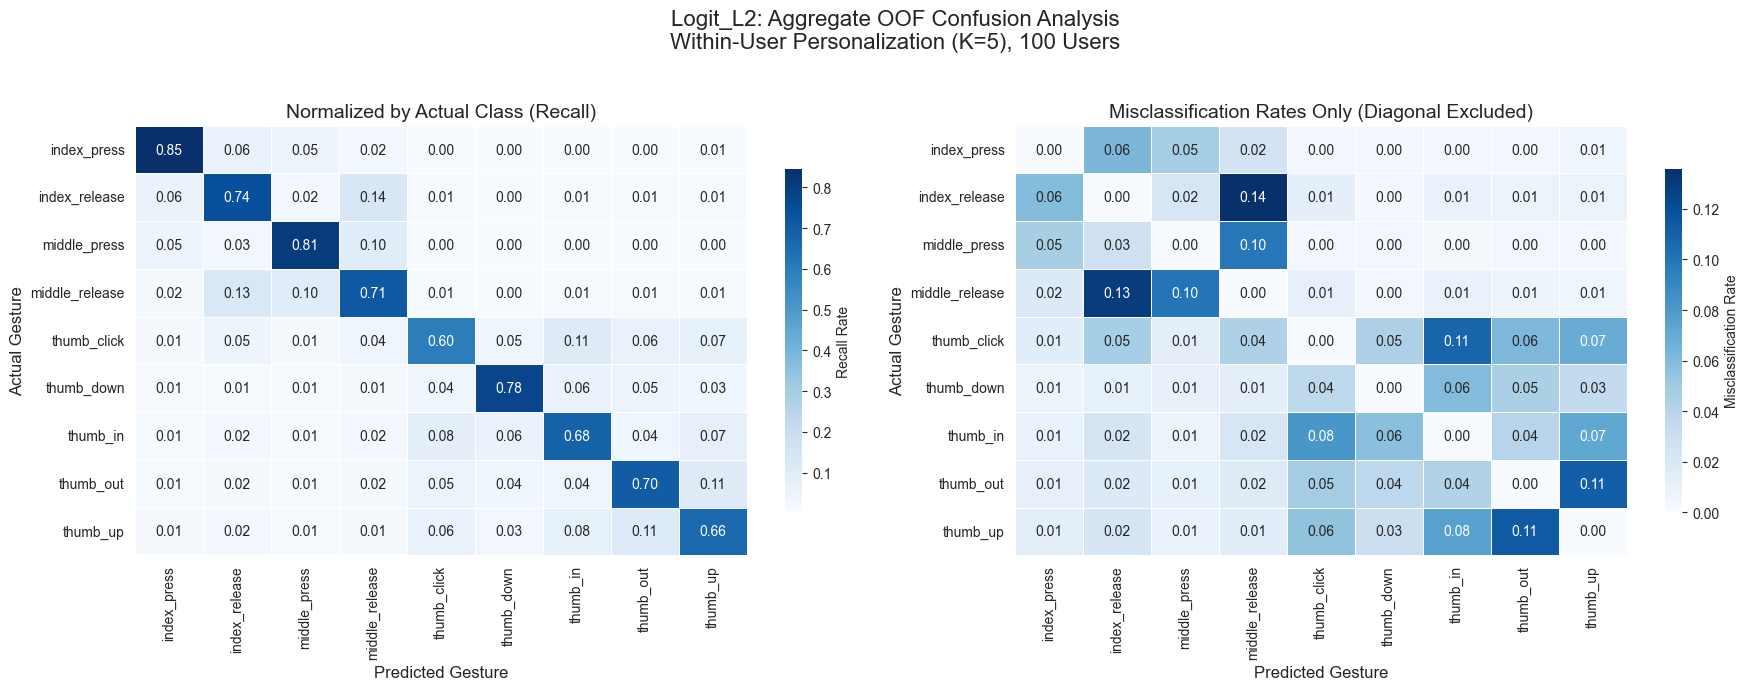

In [22]:
sns.set_style("whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'{best_model_name}: Aggregate OOF Confusion Analysis\nWithin-User Personalization (K={k_folds}), {users_processed} Users', fontsize=16)

# Plot: Normalized (Recall)
heatmap1 = sns.heatmap(
    conf_mat_norm_df,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    cbar_kws={'label': 'Recall Rate', 'shrink': 0.8},
    linewidths=0.5,
    ax=ax1
)
ax1.set_title('Normalized by Actual Class (Recall)', fontsize=14)
ax1.set_ylabel('Actual Gesture', fontsize=12)
ax1.set_xlabel('Predicted Gesture', fontsize=12)

# Plot: Normalized w/ diagonal excluded (misclassifications only)
heatmap2 = sns.heatmap(
    conf_mat_norm_no_diag_df,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    cbar_kws={'label': 'Misclassification Rate', 'shrink': 0.8},
    linewidths=0.5,
    ax=ax2
)
ax2.set_title('Misclassification Rates Only (Diagonal Excluded)', fontsize=14)
ax2.set_ylabel('Actual Gesture', fontsize=12)
ax2.set_xlabel('Predicted Gesture', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [23]:
# Calculate per-gesture performance metrics
gesture_performance = []
for i, gesture in enumerate(class_names):
    recall = conf_mat_norm[i, i]  # Diagonal 
    misclassification_rate = 1 - recall
    total_errors = conf_mat[i].sum() - conf_mat[i, i]
    major_confusion = class_names[conf_mat_norm_no_diag[i].argmax()] if conf_mat_norm_no_diag[i].max() > 0 else 'None'
    major_confusion_rate = conf_mat_norm_no_diag[i].max()
    
    gesture_performance.append({
        'Gesture': gesture,
        'Recall': recall,
        'Misclassification_Rate': misclassification_rate,
        'Total_Errors': total_errors,
        'Major_Confusion': major_confusion,
        'Major_Confusion_Rate': major_confusion_rate
    })

performance_df = pd.DataFrame(gesture_performance).sort_values('Recall', ascending=False)
# print(performance_df.round(4))

# Gesture performance ranking (by Recall)
performance_df

,Gesture,Recall,Misclassification_Rate,Total_Errors,Major_Confusion,Major_Confusion_Rate
0,index_press,0.845640,0.154360,2473,index_release,0.062605
2,middle_press,0.808861,0.191139,3184,middle_release,0.098631
5,thumb_down,0.778493,0.221507,1549,thumb_in,0.060489
1,index_release,0.740519,0.259481,4338,middle_release,0.135901
3,middle_release,0.713858,0.286142,4877,index_release,0.129254
7,thumb_out,0.700954,0.299046,2320,thumb_up,0.111111
6,thumb_in,0.683407,0.316593,2364,thumb_click,0.081827
8,thumb_up,0.664191,0.335809,2532,thumb_out,0.113263
4,thumb_click,0.595748,0.404252,2548,thumb_in,0.107885


In [24]:
# ID systematic confusion patterns
confusion_patterns = []
for i, true_gesture in enumerate(class_names):
    for j, pred_gesture in enumerate(class_names):
        if i != j and conf_mat_norm_no_diag[i, j] > 0.1:
            confusion_patterns.append({
                'True_Gesture': true_gesture,
                'Predicted_Gesture': pred_gesture,
                'Confusion_Rate': conf_mat_norm_no_diag[i, j],
                'Raw_Count': conf_mat[i, j],
                'Symmetry_Rate': conf_mat_norm_no_diag[j, i]  # Reverse confusion rate
            })

confusion_df = pd.DataFrame(confusion_patterns).sort_values('Confusion_Rate', ascending=False)
# print(confusion_df.round(4))

# Most confused gestures
# SYSTEMATIC CONFUSION PATTERNS (rate > 0.1)
confusion_df

,True_Gesture,Predicted_Gesture,Confusion_Rate,Raw_Count,Symmetry_Rate
0,index_release,middle_release,0.135901,2272,0.129254
1,middle_release,index_release,0.129254,2203,0.135901
5,thumb_up,thumb_out,0.113263,854,0.111111
4,thumb_out,thumb_up,0.111111,862,0.113263
3,thumb_click,thumb_in,0.107885,680,0.081827
2,middle_release,middle_press,0.100211,1708,0.098631


In [25]:
# Calculate overall performance summary
print(f"Mean Recall: {performance_df['Recall'].mean():.4f}")
print(f"Recall SD: {performance_df['Recall'].std():.4f}")
print(f"Worst gesture: {performance_df.iloc[-1]['Gesture']} (Recall: {performance_df.iloc[-1]['Recall']:.4f})")
print(f"Best gesture: {performance_df.iloc[0]['Gesture']} (Recall: {performance_df.iloc[0]['Recall']:.4f})")
print(f"Gestures with Recall < 0.7: {sum(performance_df['Recall'] < 0.7)}/{len(class_names)}")
print(f"Gestures with Recall > 0.9: {sum(performance_df['Recall'] > 0.9)}/{len(class_names)}")

Mean Recall: 0.7257
Recall SD: 0.0771
Worst gesture: thumb_click (Recall: 0.5957)
Best gesture: index_press (Recall: 0.8456)
Gestures with Recall < 0.7: 3/9
Gestures with Recall > 0.9: 0/9


- High confusion rates (e.g., >0.1) indicate neuromuscular similarity or feature overlap
- Asymmetric patterns suggest systematic bias in gesture recognition
- Recall < 0.7 indicates gestures requiring improved discrimination

In [26]:
# Summarize performance
final_accuracy = accuracy_score(y_true_all, y_pred_all)
final_f1 = f1_score(y_true_all, y_pred_all, average='macro')
print(f"Aggregate Performance across {len(y_true_all)} samples")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Macro: {final_f1:.4f}")

Aggregate Performance across 102502 samples
Accuracy: 0.7445
F1 Macro: 0.7273


## Experiment documentation

**Experiments conducted:**
- `DummyClassifier` (stratified baseline)
- `Logit_L2` (linear model, selected features)
- `Logit_Weighted_L2` (linear model, selected features, class-weighted)
- `RandomForest` (ensemble, bagging)
- `DecisionTree` (decision tree)
- `Logit_All_L2` (linear model, all 160 features)
- `Logit_Weighted_All_L2` (linear model, all 160 features, class-weighted)

**Personalization strategy:**
- Within-user `StratifiedKFold` (K=5) across 100 users
- Test generalization to unseen data from same individual

**Key findings:**
- **Performance ranking by F1 Macro:**
    1. `Logit_L2`: 0.716390
    2. `Logit_Weighted_L2`: 0.709838
    3. `Logit_All_L2`: 0.701264
    4. `Logit_Weighted_All_L2`: 0.700532
    5. `RandomForest`: 0.613754
    6. `DecisionTree`: 0.506332
    7. `DummyClassifier`: 0.108575

- **Performance ranking by accuracy:**
    1. `Logit_L2`: 0.734007
    2. `Logit_Weighted_L2`: 0.728891
    3. `Logit_All_L2`: 0.724993
    4. `Logit_Weighted_All_L2`: 0.722341
    5. `RandomForest`: 0.642841
    6. `DecisionTree`: 0.547070
    7. `DummyClassifier`: 0.146502
- Selected-feature models (37 features) outperform full-feature models (160 features) for within-user personalization
- Standard logistic regression outperforms class-weighted versions for both feature sets
- Linear models consistently outperform ensembles for within-user personalization

**Feature analysis:**
- Models used 37 selected features
- Top features from selected set include: `ch05_rms`, `ch04_rms`, `ch03_maxabs`, `ch06_rms`, `ch10_rms`

**Diagnostics:**
- Primary confusion: Index/middle release gestures (index_release ↔ middle_release: 0.129860 and 0.127786 cross-error)
- Thumb gestures show systematic directional confusions (thumb_out ↔ thumb_up: 0.110421 and 0.110110)
- Thumb_click ↔ thumb_in: 0.110164 confusion rate
- Press gestures most reliable (index_press: 0.857217 recall, middle_press: 0.817544 recall)
- Thumb gestures most challenging (thumb_click: 0.594340 recall)
- 3 out of 9 gestures have recall below 0.7, indicating room for improvement

**Performance summary:**
- Best model accuracy: 0.734007 (Logit_L2 with selected features)
- Best model F1 Macro: 0.716390 (Logit_L2 with selected features)
- Aggregate accuracy across all samples: 0.7510
- Aggregate F1 Macro across all samples: 0.7316
- Mean recall across gestures: 0.7302
- High user variability (accuracy std: 0.119530 for best model)

**Decision:**
- Proceed with `Logit_L2` (with selected 37 features) for final validation
- Rationale: Best overall performance on both accuracy and F1 Macro metrics, optimal feature efficiency
- Note: Selected-feature models demonstrate improved personalization performance compared to full-feature models, suggesting feature selection effectively captures user-specific signal patterns while reducing dimensionality and enhancing interpretability

In [27]:
# Example XGBoost DMatrix setup (disabled by default)
if False:
    # XGBoost model
    import xgboost as xgb
    
    # Replace X_train, y_train, X_valid, y_valid with your prepared data
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    valid_dmatrix = xgb.DMatrix(X_valid, label=y_valid)
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
    }
    
    evals = [(train_dmatrix, 'train'), (valid_dmatrix, 'valid')]
    model = xgb.train(
        params=params,
        dtrain=train_dmatrix,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=25,
        verbose_eval=50,
    )
    
    # Example prediction
    # preds = model.predict(valid_dmatrix)
